In [1]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from glob import glob
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, f1_score

from skimage.io import imread
from skimage.transform import resize

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from google.colab import drive

In [2]:
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/archive (3).zip'
extract_path = '/content/unzipped_data'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("✅ Extraction complete!")
else:
    print("✅ Data already extracted!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Data already extracted!


In [3]:
# Reading the metadata of the dataset
metadata_path = '/content/unzipped_data/HAM10000_metadata.csv'
df_metadata = pd.read_csv(metadata_path)

# Display the first 10 rows
df_metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
# Mapping lesion type names and IDs
lesion_type_mapping = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_id_mapping = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

# Defining full and short lesion names
lesion_full_names = [
    'Melanocytic nevi', 'Melanoma', 'Benign keratosis-like lesions',
    'Basal cell carcinoma', 'Actinic keratoses', 'Vascular lesions', 'Dermatofibroma'
]

lesion_short_names = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

# Adding new columns for lesion type and lesion ID
df_metadata['lesion_type'] = df_metadata['dx'].map(lesion_type_mapping)
df_metadata['lesion_id'] = df_metadata['dx'].map(lesion_id_mapping)

# Displaying basic dataset information
print('✅ Total number of images:', len(df_metadata))
print('⚠️  The dataset is unbalanced: "Melanocytic nevi" class appears much more frequently.')

# Displaying the count of each lesion type
df_metadata['lesion_type'].value_counts()


✅ Total number of images: 10015
⚠️  The dataset is unbalanced: "Melanocytic nevi" class appears much more frequently.


,count
lesion_type,
Melanocytic nevi,6705
Melanoma,1113
Benign keratosis-like lesions,1099
Basal cell carcinoma,514
Actinic keratoses,327
Vascular lesions,142
Dermatofibroma,115


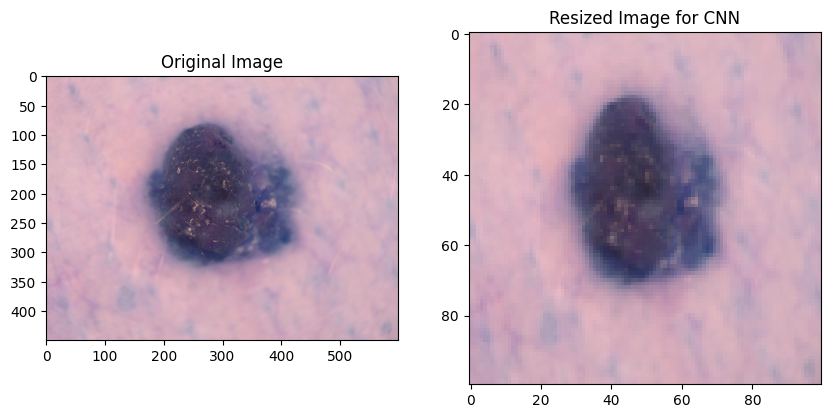

In [5]:
# Reading a random image from the dataset
image_filenames = np.array(df_metadata['image_id'])
selected_image_path = '/content/unzipped_data/HAM10000_images_part_1/' + str(image_filenames[25]) + '.jpg'

# Reading and resizing the selected image to 100x100
original_img = imread(selected_image_path)
resized_img = resize(original_img, (100, 100))

# Displaying the original and resized image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_img[:, :, ::-1])
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(resized_img[:, :, ::-1])
plt.title('Resized Image for CNN')
plt.show()


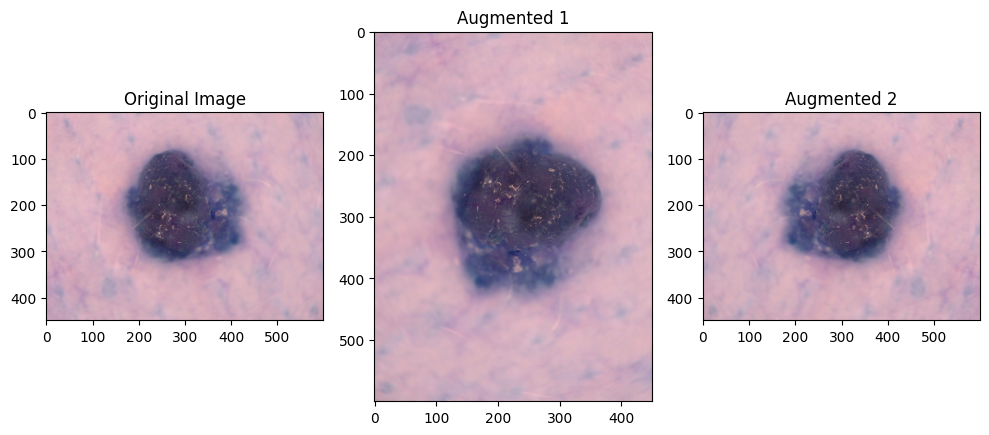

In [7]:
# Function to produce new augmented images (ONLY 2 augmentations)
def augment_image(input_img: np.ndarray) -> tuple:
    """
    Function to create 2 augmented versions (rotation and horizontal flip) of the given image,
    to increase dataset size moderately and avoid RAM overload.

    Args:
        input_img (np.ndarray): Image array read using cv2.

    Returns:
        augmented_images (tuple): Tuple containing augmented images.
    """
    img_rot90 = cv2.rotate(input_img, cv2.ROTATE_90_CLOCKWISE)
    img_flip_horiz = cv2.flip(input_img, 1)
    augmented_images = (img_rot90, img_flip_horiz)
    return augmented_images

# Function to display the original and augmented images
def display_augmented_images() -> None:
    """
    Display the original image and its two augmented versions created by augment_image() function.
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(original_img[:, :, ::-1])
    plt.title('Original Image')

    for idx in range(2):
        plt.subplot(1, 3, idx + 2)
        plt.imshow(augmented_imgs[idx][:, :, ::-1])
        plt.title(f'Augmented {idx+1}')

    plt.tight_layout()
    plt.show()

# Invoking the augmentation and display functions
augmented_imgs = augment_image(original_img)
display_augmented_images()


In [9]:
# Initialize lists to store resized images and corresponding labels
X_data = []
y_labels = []

# Listing all files from part 1 and part 2 directories
image_list_part1 = os.listdir('/content/unzipped_data/HAM10000_images_part_1/')
image_list_part2 = os.listdir('/content/unzipped_data/HAM10000_images_part_2/')
all_images = image_list_part1 + image_list_part2

# Merge image paths
image_paths = {}
for img in image_list_part1:
    image_paths[img.replace('.jpg', '')] = '/content/unzipped_data/HAM10000_images_part_1/' + img
for img in image_list_part2:
    image_paths[img.replace('.jpg', '')] = '/content/unzipped_data/HAM10000_images_part_2/' + img

# Define how many images we want per class
target_counts = {
    'nv': 500,     # No augmentation
    'mel': 500,    # Augmentation needed
    'bkl': 500,    # Augmentation needed
    'bcc': 300,    # Augmentation needed
    'akiec': 300,  # Augmentation needed
    'vasc': 150,   # Augmentation needed
    'df': 150      # Augmentation needed
}

# Define which classes need augmentation
augment_classes = ['mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

# Counters to track selected images per class
selected_counts = {key: 0 for key in target_counts.keys()}

# Counter to track how many images we have already processed
total_loaded = 0

# Start selecting images
for img_id in image_paths.keys():
    lesion_info = df_metadata[df_metadata['image_id'] == img_id]
    lesion_type = lesion_info['dx'].values[0]
    lesion_id = lesion_info['lesion_id'].values[0]

    # If this lesion type is in our target classes
    if lesion_type in target_counts:
        if selected_counts[lesion_type] < target_counts[lesion_type]:
            # Read and resize the image
            img = imread(image_paths[img_id])
            img_resized = resize(img, (100, 100))
            X_data.append(img_resized)
            y_labels.append(lesion_id)
            selected_counts[lesion_type] += 1
            total_loaded += 1

            # If augmentation is needed for this class
            if lesion_type in augment_classes:
                augmented_images = augment_image(img_resized)
                for aug_img in augmented_images:
                    X_data.append(aug_img)
                    y_labels.append(lesion_id)
                    total_loaded += 1  # Count augment images too

            # Print every 100 images loaded
            if total_loaded % 100 == 0:
                print(f'✅ {total_loaded} images loaded')

    # Stop early if all classes are filled
    if all(selected_counts[key] >= target_counts[key] for key in target_counts):
        break

# Display results
print('✅ Total selected images:', len(X_data))
for lesion_type, count in selected_counts.items():
    print(f"Class {lesion_type}: {count} original images selected")


✅ 100 images loaded
✅ 200 images loaded
✅ 300 images loaded
✅ 400 images loaded
✅ 500 images loaded
✅ 600 images loaded
✅ 700 images loaded
✅ 800 images loaded
✅ 900 images loaded
✅ 1400 images loaded
✅ 1700 images loaded
✅ 2000 images loaded
✅ 2300 images loaded
✅ 2600 images loaded
✅ 2900 images loaded
✅ 3200 images loaded
✅ 3500 images loaded
✅ 3800 images loaded
✅ 4100 images loaded
✅ 4400 images loaded
✅ 4700 images loaded
✅ 5000 images loaded
✅ 5300 images loaded
✅ 5600 images loaded
✅ 5900 images loaded
✅ Total selected images: 6071
Class nv: 500 original images selected
Class mel: 500 original images selected
Class bkl: 500 original images selected
Class bcc: 300 original images selected
Class akiec: 300 original images selected
Class vasc: 142 original images selected
Class df: 115 original images selected


In [10]:
# Converting lists to numpy arrays
X_data = np.array(X_data)
y_labels = np.array(y_labels)

# Converting target labels to categorical format for softmax activation
y_data_categorical = to_categorical(y_labels, num_classes=7)

In [12]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_data,                   # Images array
    y_data_categorical,        # One-hot encoded labels
    test_size=0.20,            # 20% for testing
    random_state=50,           # For reproducibility
    stratify=y_labels          # Stratify based on original labels (before categorical)
)

# Display the shapes of the train and test datasets
print('✅ Train dataset shape:', X_train.shape)
print('✅ Test dataset shape:', X_test.shape)


✅ Train dataset shape: (4856, 100, 100, 3)
✅ Test dataset shape: (1215, 100, 100, 3)


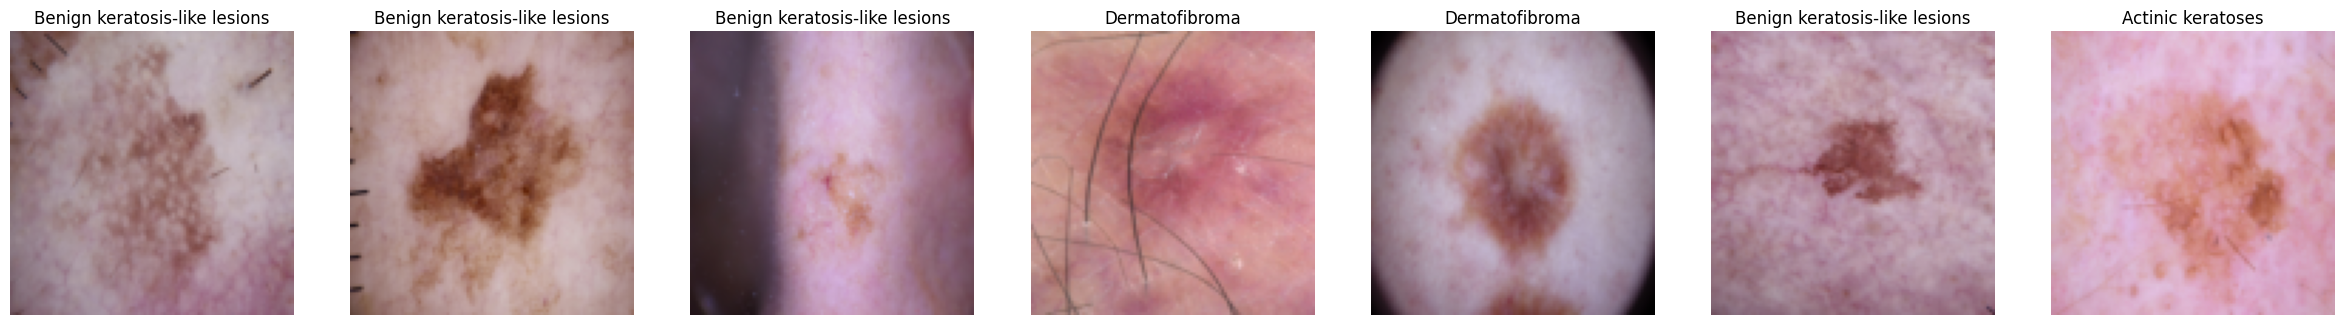

In [13]:
def show_class_examples() -> None:
    """
    Display examples of each class from the training set.
    """
    # Figure, Axes
    _, ax = plt.subplots(1, 7, figsize=(30, 30))

    for i in range(7):
        ax[i].set_axis_off()                                 # Remove axes
        ax[i].imshow(X_train[i])                             # Display the image
        class_idx = np.argmax(y_train[i])                    # Get class index from one-hot encoding
        ax[i].set_title(lesion_full_names[class_idx])        # Set title based on lesion names

# Calling the function to show images
show_class_examples()


In [14]:
from sklearn.utils.class_weight import compute_class_weight

def estimate_class_weights(label_array: np.ndarray) -> dict:
    """
    Estimate class weights for unbalanced datasets.

    Args:
        label_array (np.ndarray): numpy array of integer class labels.

    Returns:
        dict: Estimated class weights for unbalanced datasets.
    """
    classes = np.unique(label_array)
    class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=label_array)
    class_weights = dict(zip(classes, np.around(class_weights, 2)))
    return class_weights

# Compute class weights based on y_labels
new_class_weights = estimate_class_weights(y_labels)

# Display the computed class weights
print('⚖️ The problem is unbalanced. We need to provide class weights:')
print(new_class_weights)


⚖️ The problem is unbalanced. We need to provide class weights:
{np.int64(0): np.float64(1.73), np.int64(1): np.float64(0.58), np.int64(2): np.float64(0.58), np.int64(3): np.float64(0.96), np.int64(4): np.float64(0.96), np.int64(5): np.float64(2.04), np.int64(6): np.float64(2.51)}


In [16]:
# Build the CNN model
model = Sequential()

# [+] 1st Convolutional Block
model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=(4, 4),
                 activation='relu', input_shape=(100, 100, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# [+] 2nd Convolutional Block
model.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# [+] 3rd Convolutional Block
model.add(Conv2D(filters=384, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu', padding='same'))
model.add(BatchNormalization())

# [+] 4th Convolutional Block
model.add(Conv2D(filters=384, kernel_size=(1, 1), strides=(1, 1),
                 activation='relu', padding='same'))
model.add(BatchNormalization())

# [+] 5th Convolutional Block
model.add(Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1),
                 activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))

# [+] Flatten Layer
model.add(Flatten())

# [+] 6th Dense Layer
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

# [+] 7th Dense Layer
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))

# [+] Output Layer
model.add(Dense(7, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K

In [26]:
##########################
### [+] Training phase ###
##########################

# Function to create model checkpoint callback
def model_checkpoint_callback() -> ModelCheckpoint:
    """
    Create a callback to save the best model during training.

    Returns:
        ModelCheckpoint: Callback for saving the best model.
    """
    checkpoint = ModelCheckpoint(
        filepath='model_best.h5',             # Result filename
        save_weights_only=False,              # Save full model (not just weights)
        monitor='val_accuracy',               # Monitor validation accuracy
        mode='auto',                          # Automatically decide whether to maximize or minimize
        save_best_only=True,                  # Save only if the model improves
        verbose=1                             # Verbose output
    )
    return checkpoint

# Early stopping to monitor validation accuracy
early_stopping = EarlyStopping(
    patience=30,              # patience is less than 100 to avoid overfitting (30 better)
    monitor='val_accuracy',   # Monitor validation accuracy
    restore_best_weights=True # Restore best weights when early stopping
)

# Create model checkpoint
checkpoint_callback = model_checkpoint_callback()

# Optimizer settings
optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-3)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Data augmentation
datagen = ImageDataGenerator(
    zoom_range=0.2,
    horizontal_flip=True,
    shear_range=0.2
)
datagen.fit(X_train)

# Training settings
batch_size = 32
epochs = 100

# Model training
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    shuffle=True,
    callbacks=[early_stopping, checkpoint_callback],
    validation_data=(X_test, y_test),
    class_weight=new_class_weights
)


Epoch 1/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2776 - loss: 2.2067
Epoch 1: val_accuracy improved from -inf to 0.14815, saving model to model_best.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.2778 - loss: 2.2054 - val_accuracy: 0.1481 - val_loss: 2.0681
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4199 - loss: 1.5588
Epoch 2: val_accuracy improved from 0.14815 to 0.16214, saving model to model_best.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.4200 - loss: 1.5586 - val_accuracy: 0.1621 - val_loss: 2.3698
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4638 - loss: 1.3491
Epoch 3: val_accuracy improved from 0.16214 to 0.26502, saving model to model_best.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.4639 - loss: 1.3490 - val_accuracy: 0.2650 - val_loss: 2.2507
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4951 - loss: 1.2198
Epoch 4: val_accuracy did not improve from 0.26502
152/152 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.4951 - loss: 1.2201 - val_accuracy: 0.2321 - val_loss: 2.0797
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5274 - loss: 1.1598
Epoch 5: val_accuracy improved from 0.26502 to 0.30864, saving model to model_best.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 214s 1s/step - accuracy: 0.5274 - loss: 1.1598 - val_accuracy: 0.3086 - val_loss: 1.9951
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5497 - loss: 1.0996
Epoch 6: val_accuracy did not improve from 0.30864
152/152 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.5497 - loss: 1.0995 - val_accuracy: 0.1449 - val_loss: 4.7120
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5695 - loss: 1.0510
Epoch 7: val_accuracy did not improve from 0.30864
152/152 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.5695 - loss: 1.0511 - val_accuracy: 0.3086 - val_loss: 2.2584
Epoch 8/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5767 - loss: 1.0265
Epoch 8: val_accuracy did not improve from 0.30864
152/152 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.5767 - loss: 1.0265 - val_accuracy: 0.1885 - val_loss: 4.2179
Epoch 9/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5809 - loss: 1.0006
Epoch 9: val_accuracy improved 

152/152 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.5810 - loss: 1.0005 - val_accuracy: 0.3827 - val_loss: 1.5245
Epoch 10/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6049 - loss: 0.9324
Epoch 10: val_accuracy did not improve from 0.38272
152/152 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.6048 - loss: 0.9325 - val_accuracy: 0.1440 - val_loss: 5.3055
Epoch 11/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6304 - loss: 0.8941
Epoch 11: val_accuracy did not improve from 0.38272
152/152 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.6304 - loss: 0.8941 - val_accuracy: 0.3086 - val_loss: 3.2758
Epoch 12/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6447 - loss: 0.8148
Epoch 12: val_accuracy did not improve from 0.38272
152/152 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.6446 - loss: 0.8151 - val_accuracy: 0.2329 - val_loss: 5.1502
Epoch 13/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6434 - loss: 0.8354
Epoch 13: val_accuracy d

152/152 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.6391 - loss: 0.8487 - val_accuracy: 0.6074 - val_loss: 1.0821
Epoch 15/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6637 - loss: 0.7702
Epoch 15: val_accuracy did not improve from 0.60741
152/152 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.6636 - loss: 0.7704 - val_accuracy: 0.2584 - val_loss: 3.8064
Epoch 16/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6912 - loss: 0.7591
Epoch 16: val_accuracy improved from 0.60741 to 0.61811, saving model to model_best.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.6911 - loss: 0.7590 - val_accuracy: 0.6181 - val_loss: 0.9264
Epoch 17/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6914 - loss: 0.7630
Epoch 17: val_accuracy did not improve from 0.61811
152/152 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.6913 - loss: 0.7629 - val_accuracy: 0.5432 - val_loss: 1.3700
Epoch 18/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6842 - loss: 0.7266
Epoch 18: val_accuracy did not improve from 0.61811
152/152 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.6843 - loss: 0.7265 - val_accuracy: 0.4296 - val_loss: 1.7542
Epoch 19/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7036 - loss: 0.6531
Epoch 19: val_accuracy did not improve from 0.61811
152/152 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.7036 - loss: 0.6532 - val_accuracy: 0.3218 - val_loss: 2.6342
Epoch 20/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7223 - loss: 0.6213
Epoch 20: val_accuracy d

152/152 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.7998 - loss: 0.4232 - val_accuracy: 0.6609 - val_loss: 0.9931
Epoch 32/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8045 - loss: 0.4353
Epoch 32: val_accuracy did not improve from 0.66091
152/152 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.8044 - loss: 0.4354 - val_accuracy: 0.5119 - val_loss: 1.7484
Epoch 33/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8211 - loss: 0.4034
Epoch 33: val_accuracy improved from 0.66091 to 0.66831, saving model to model_best.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.8210 - loss: 0.4035 - val_accuracy: 0.6683 - val_loss: 0.9485
Epoch 34/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8186 - loss: 0.4169
Epoch 34: val_accuracy did not improve from 0.66831
152/152 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.8186 - loss: 0.4168 - val_accuracy: 0.4716 - val_loss: 2.1592
Epoch 35/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8136 - loss: 0.4212
Epoch 35: val_accuracy did not improve from 0.66831
152/152 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.8135 - loss: 0.4214 - val_accuracy: 0.3342 - val_loss: 2.6244
Epoch 36/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8066 - loss: 0.4013
Epoch 36: val_accuracy improved from 0.66831 to 0.71029, saving model to model_best.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.8066 - loss: 0.4014 - val_accuracy: 0.7103 - val_loss: 0.8567
Epoch 37/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8332 - loss: 0.3784
Epoch 37: val_accuracy did not improve from 0.71029
152/152 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.8332 - loss: 0.3784 - val_accuracy: 0.4930 - val_loss: 2.0942
Epoch 38/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8472 - loss: 0.3432
Epoch 38: val_accuracy did not improve from 0.71029
152/152 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.8471 - loss: 0.3433 - val_accuracy: 0.5893 - val_loss: 1.1933
Epoch 39/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8398 - loss: 0.3314
Epoch 39: val_accuracy did not improve from 0.71029
152/152 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.8397 - loss: 0.3315 - val_accuracy: 0.5712 - val_loss: 1.3394
Epoch 40/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8390 - loss: 0.3166
Epoch 40: val_accuracy i

152/152 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.8390 - loss: 0.3166 - val_accuracy: 0.7621 - val_loss: 0.7092
Epoch 41/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8711 - loss: 0.2660
Epoch 41: val_accuracy did not improve from 0.76214
152/152 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.8710 - loss: 0.2662 - val_accuracy: 0.3934 - val_loss: 2.6989
Epoch 42/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8468 - loss: 0.3423
Epoch 42: val_accuracy did not improve from 0.76214
152/152 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.8468 - loss: 0.3424 - val_accuracy: 0.6008 - val_loss: 1.4308
Epoch 43/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8618 - loss: 0.2852
Epoch 43: val_accuracy did not improve from 0.76214
152/152 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.8618 - loss: 0.2853 - val_accuracy: 0.6222 - val_loss: 1.0688
Epoch 44/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8741 - loss: 0.2554
Epoch 44: val_accuracy d

152/152 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.9217 - loss: 0.1770 - val_accuracy: 0.7720 - val_loss: 0.6757
Epoch 57/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9248 - loss: 0.1635
Epoch 57: val_accuracy did not improve from 0.77202
152/152 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.9247 - loss: 0.1636 - val_accuracy: 0.6469 - val_loss: 1.2413
Epoch 58/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9160 - loss: 0.1790
Epoch 58: val_accuracy did not improve from 0.77202
152/152 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9160 - loss: 0.1790 - val_accuracy: 0.6840 - val_loss: 1.1049
Epoch 59/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8953 - loss: 0.2256
Epoch 59: val_accuracy did not improve from 0.77202
152/152 ━━━━━━━━━━━━━━━━━━━━ 178s 1s/step - accuracy: 0.8954 - loss: 0.2255 - val_accuracy: 0.5029 - val_loss: 2.8732
Epoch 60/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9151 - loss: 0.2065
Epoch 60: val_accuracy d

152/152 ━━━━━━━━━━━━━━━━━━━━ 184s 1s/step - accuracy: 0.9437 - loss: 0.1413 - val_accuracy: 0.7819 - val_loss: 0.7793
Epoch 77/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9488 - loss: 0.1179
Epoch 77: val_accuracy improved from 0.78189 to 0.78848, saving model to model_best.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 185s 1s/step - accuracy: 0.9488 - loss: 0.1180 - val_accuracy: 0.7885 - val_loss: 0.7391
Epoch 78/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9411 - loss: 0.1277
Epoch 78: val_accuracy did not improve from 0.78848
152/152 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.9411 - loss: 0.1277 - val_accuracy: 0.6757 - val_loss: 1.2656
Epoch 79/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9485 - loss: 0.1109
Epoch 79: val_accuracy did not improve from 0.78848
152/152 ━━━━━━━━━━━━━━━━━━━━ 182s 1s/step - accuracy: 0.9484 - loss: 0.1111 - val_accuracy: 0.5325 - val_loss: 1.9275
Epoch 80/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9399 - loss: 0.1320
Epoch 80: val_accuracy did not improve from 0.78848
152/152 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.9398 - loss: 0.1323 - val_accuracy: 0.6979 - val_loss: 0.9258
Epoch 81/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9441 - loss: 0.1270
Epoch 81: val_accuracy d

152/152 ━━━━━━━━━━━━━━━━━━━━ 190s 1s/step - accuracy: 0.9467 - loss: 0.1239 - val_accuracy: 0.8156 - val_loss: 0.7380
Epoch 86/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9612 - loss: 0.0938
Epoch 86: val_accuracy did not improve from 0.81564
152/152 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.9611 - loss: 0.0940 - val_accuracy: 0.6914 - val_loss: 1.1438
Epoch 87/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9420 - loss: 0.1318
Epoch 87: val_accuracy did not improve from 0.81564
152/152 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.9420 - loss: 0.1318 - val_accuracy: 0.7169 - val_loss: 1.0729
Epoch 88/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9420 - loss: 0.1288
Epoch 88: val_accuracy improved from 0.81564 to 0.82798, saving model to model_best.h5


152/152 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9420 - loss: 0.1287 - val_accuracy: 0.8280 - val_loss: 0.7058
Epoch 89/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9623 - loss: 0.0866
Epoch 89: val_accuracy did not improve from 0.82798
152/152 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.9623 - loss: 0.0868 - val_accuracy: 0.6387 - val_loss: 1.6959
Epoch 90/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9358 - loss: 0.1378
Epoch 90: val_accuracy did not improve from 0.82798
152/152 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9359 - loss: 0.1377 - val_accuracy: 0.8173 - val_loss: 0.7557
Epoch 91/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9631 - loss: 0.0885
Epoch 91: val_accuracy did not improve from 0.82798
152/152 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.9630 - loss: 0.0885 - val_accuracy: 0.8033 - val_loss: 0.8943
Epoch 92/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9503 - loss: 0.1159
Epoch 92: val_accuracy d

In [28]:
from tensorflow.keras.models import load_model
import numpy as np

# Load the best saved model
best_model = load_model('./model_best.h5')

# Predict probabilities
y_pred_prob = np.around(best_model.predict(X_test), 3)

# Predicted labels
y_pred = np.argmax(y_pred_prob, axis=1)

# True labels
y_test_labels = np.argmax(y_test, axis=1)


38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step


In [29]:
from sklearn.metrics import classification_report

print(classification_report(y_test_labels, y_pred))


              precision    recall  f1-score   support

           0       0.91      0.69      0.78       100
           1       0.85      0.81      0.83       300
           2       0.83      0.80      0.81       300
           3       0.78      0.93      0.85       180
           4       0.82      0.81      0.81       180
           5       0.82      0.98      0.89        86
           6       0.82      0.84      0.83        69

    accuracy                           0.83      1215
   macro avg       0.83      0.84      0.83      1215
weighted avg       0.83      0.83      0.83      1215



In [37]:
scores = best_model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1] * 100))


38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 388ms/step - accuracy: 0.8273 - loss: 0.7551
Accuracy: 82.80%


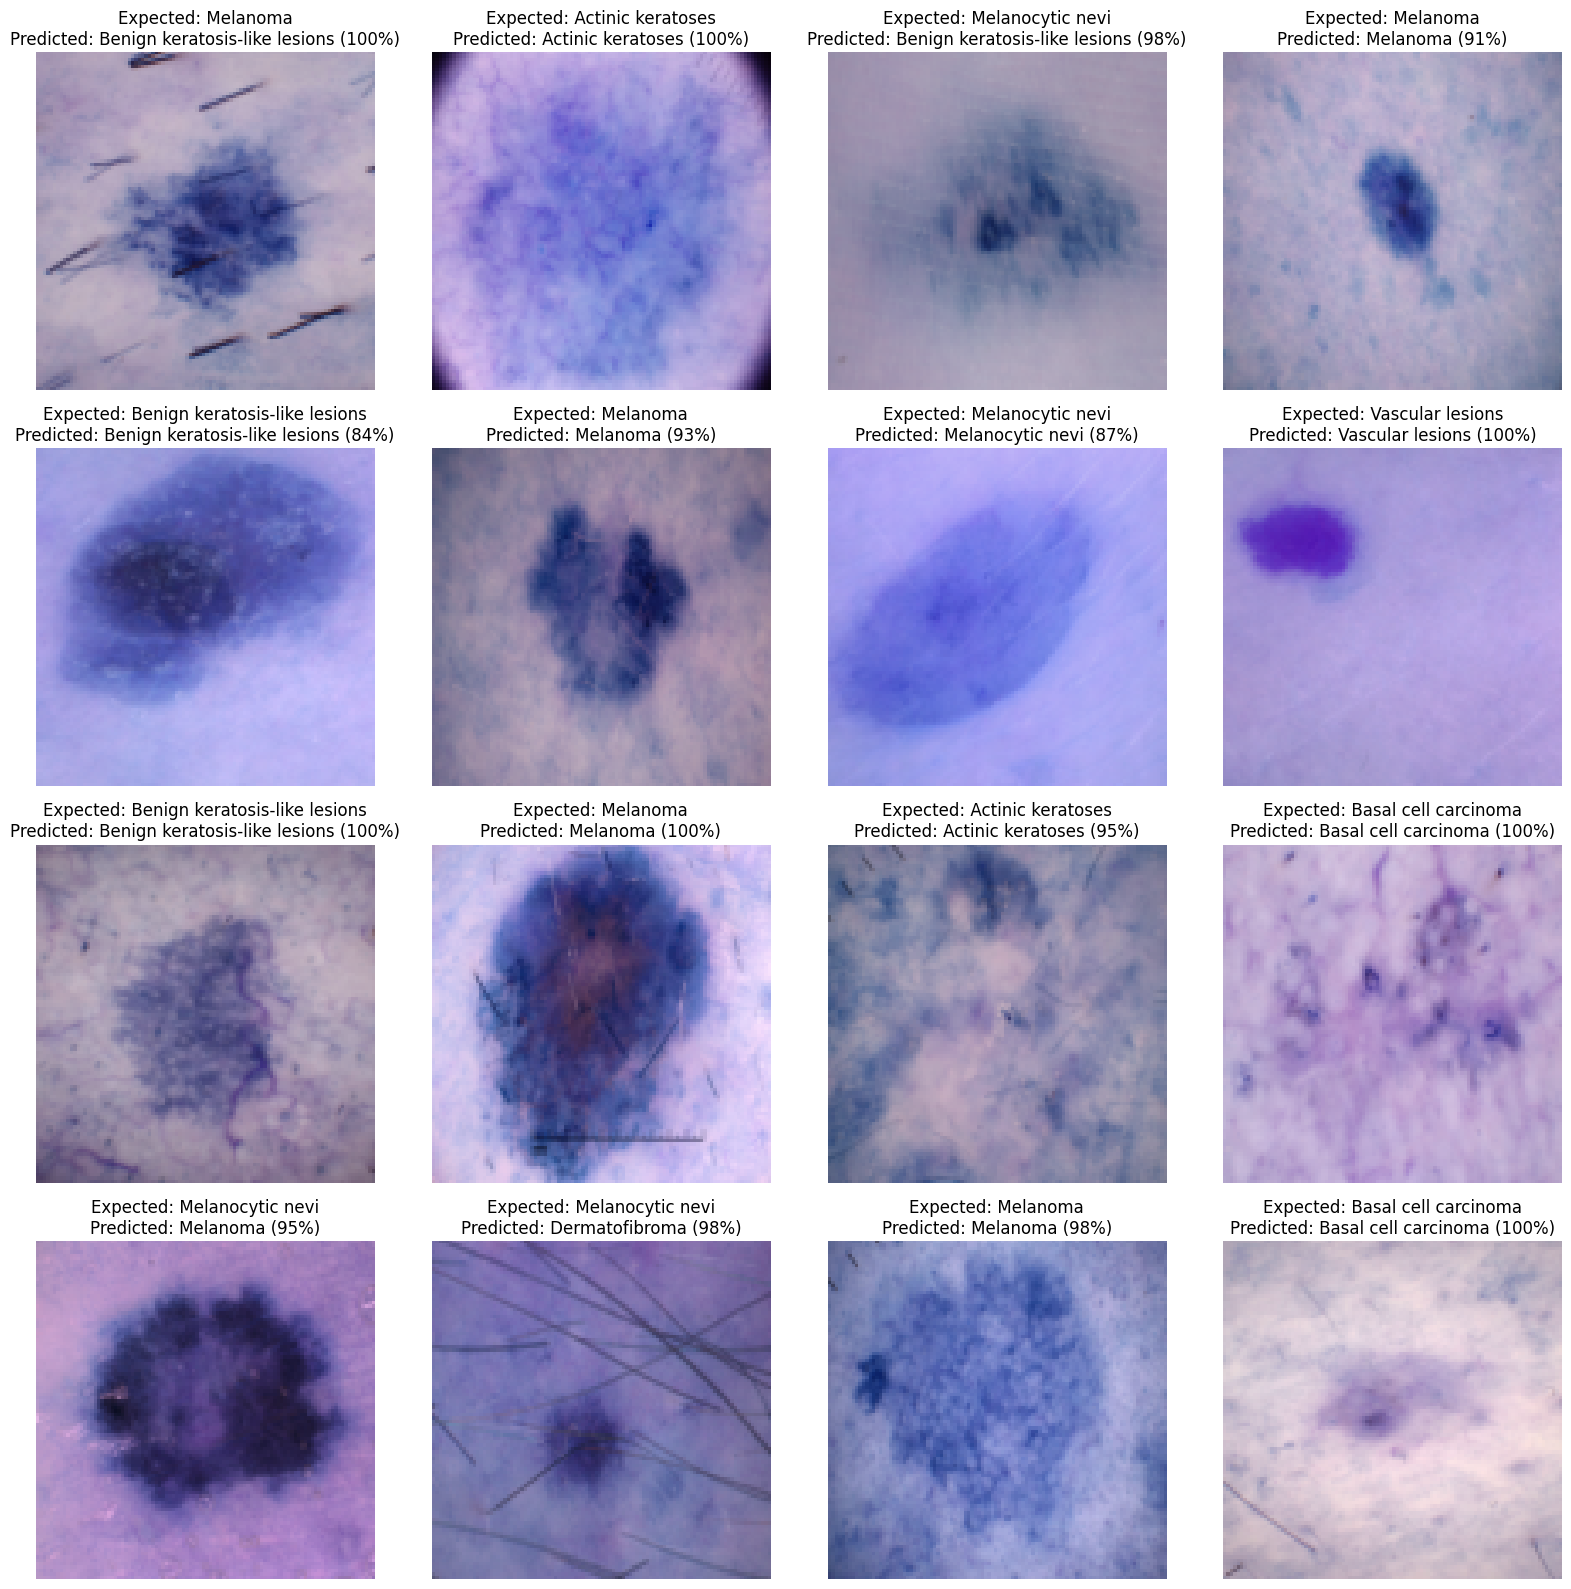

In [38]:
y_test2 = np.argmax(y_test, axis=1)

plt.figure(figsize=(16, 16))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    index = i + 100

    plt.imshow(X_test[index, :, :, ::-1])

    label_exp = lesion_names[y_test2[index]]
    label_pred = lesion_names[y_pred[index]]
    label_pred_prob = round(np.max(y_pred_prob[index]) * 100)

    plt.title(f'Expected: {label_exp}\nPredicted: {label_pred} ({label_pred_prob}%)')

    plt.axis('off')
plt.tight_layout()
plt.savefig('final_figure.png', dpi=300)
plt.show()


In [39]:
acc_tot = []

for i in range(len(lesion_names)):
    acc_per_class = round(np.mean(y_test2[y_test2 == i] == y_pred[y_test2 == i]), 2)
    label_name = lesion_names[i]
    print(f'Accuracy for {label_name} = {acc_per_class}')
    acc_tot.append(acc_per_class)


Accuracy for Melanocytic nevi = 0.69
Accuracy for Melanoma = 0.81
Accuracy for Benign keratosis-like lesions = 0.8
Accuracy for Basal cell carcinoma = 0.93
Accuracy for Actinic keratoses = 0.81
Accuracy for Vascular lesions = 0.98
Accuracy for Dermatofibroma = 0.84


In [40]:
acc_tot = np.array(acc_tot)
freq = np.unique(y_test2, return_counts=True)[1]

weighted_avg_accuracy = np.sum(acc_tot * freq) / np.sum(freq)
print(f"Weighted Average Accuracy: {round(weighted_avg_accuracy, 4)}")

Weighted Average Accuracy: 0.8292


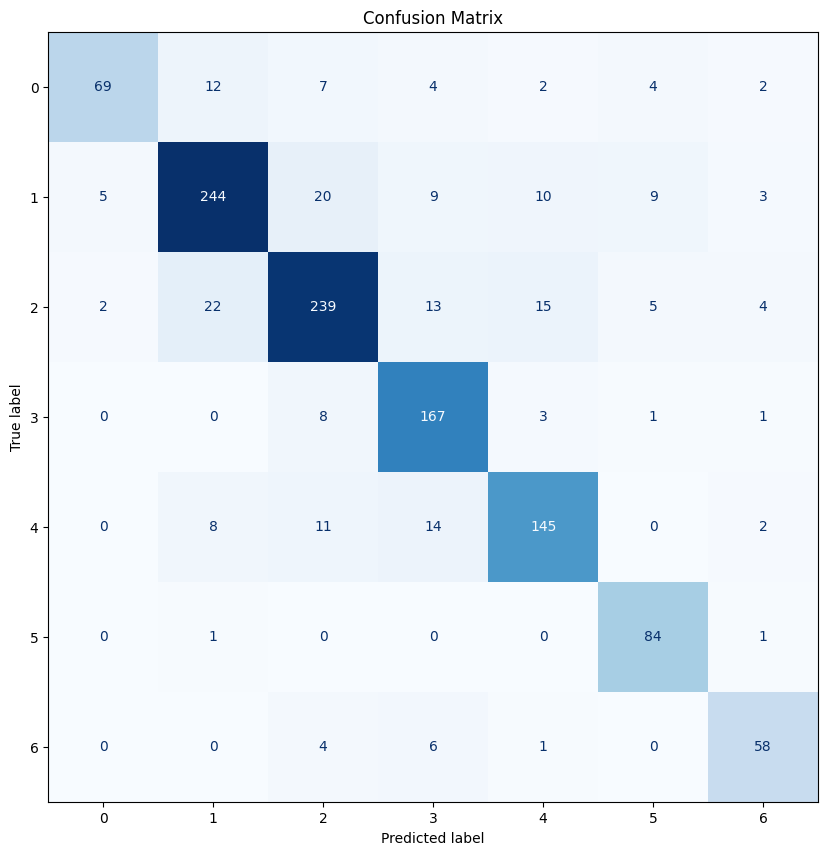

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test2, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lesion_names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, cmap='Blues', colorbar=False)
plt.title('Confusion Matrix')
plt.show()


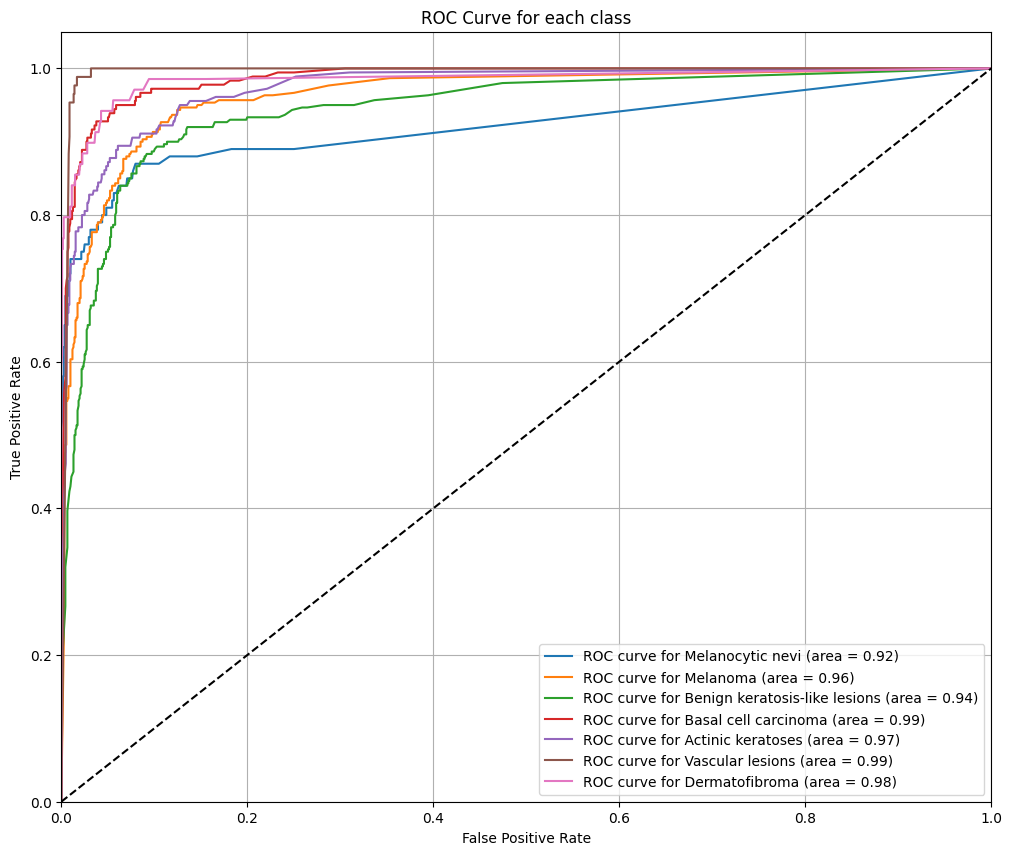

In [43]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the output
n_classes = len(lesion_names)
y_test_bin = label_binarize(y_test2, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12,10))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {lesion_names[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for each class')
plt.legend(loc="lower right")
plt.grid()
plt.show()


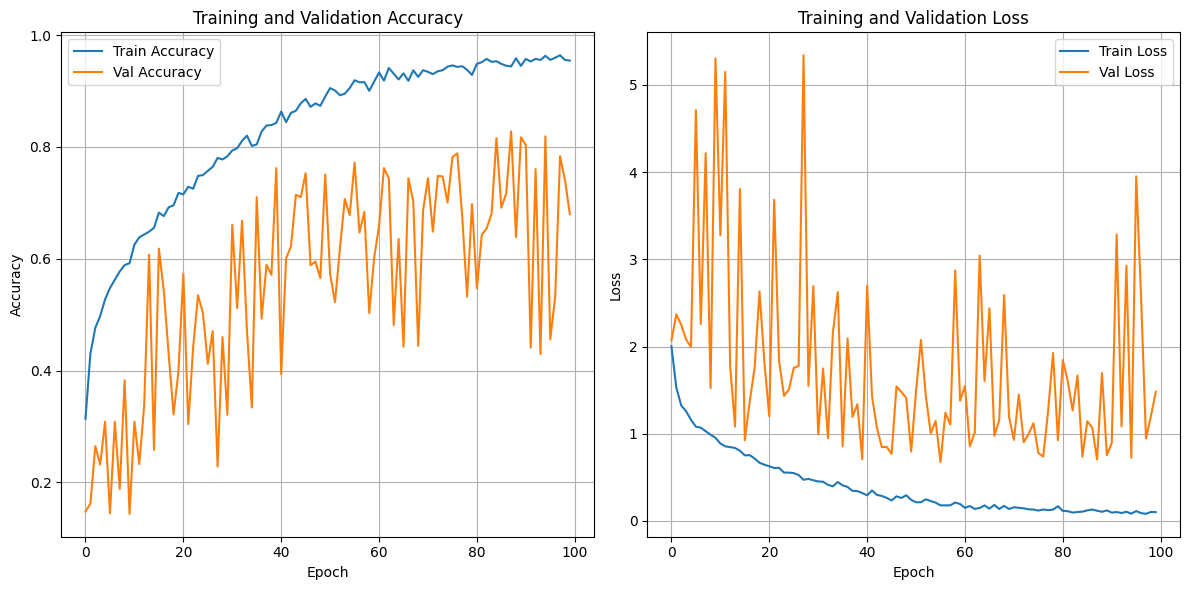

In [44]:
plt.figure(figsize=(12,6))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


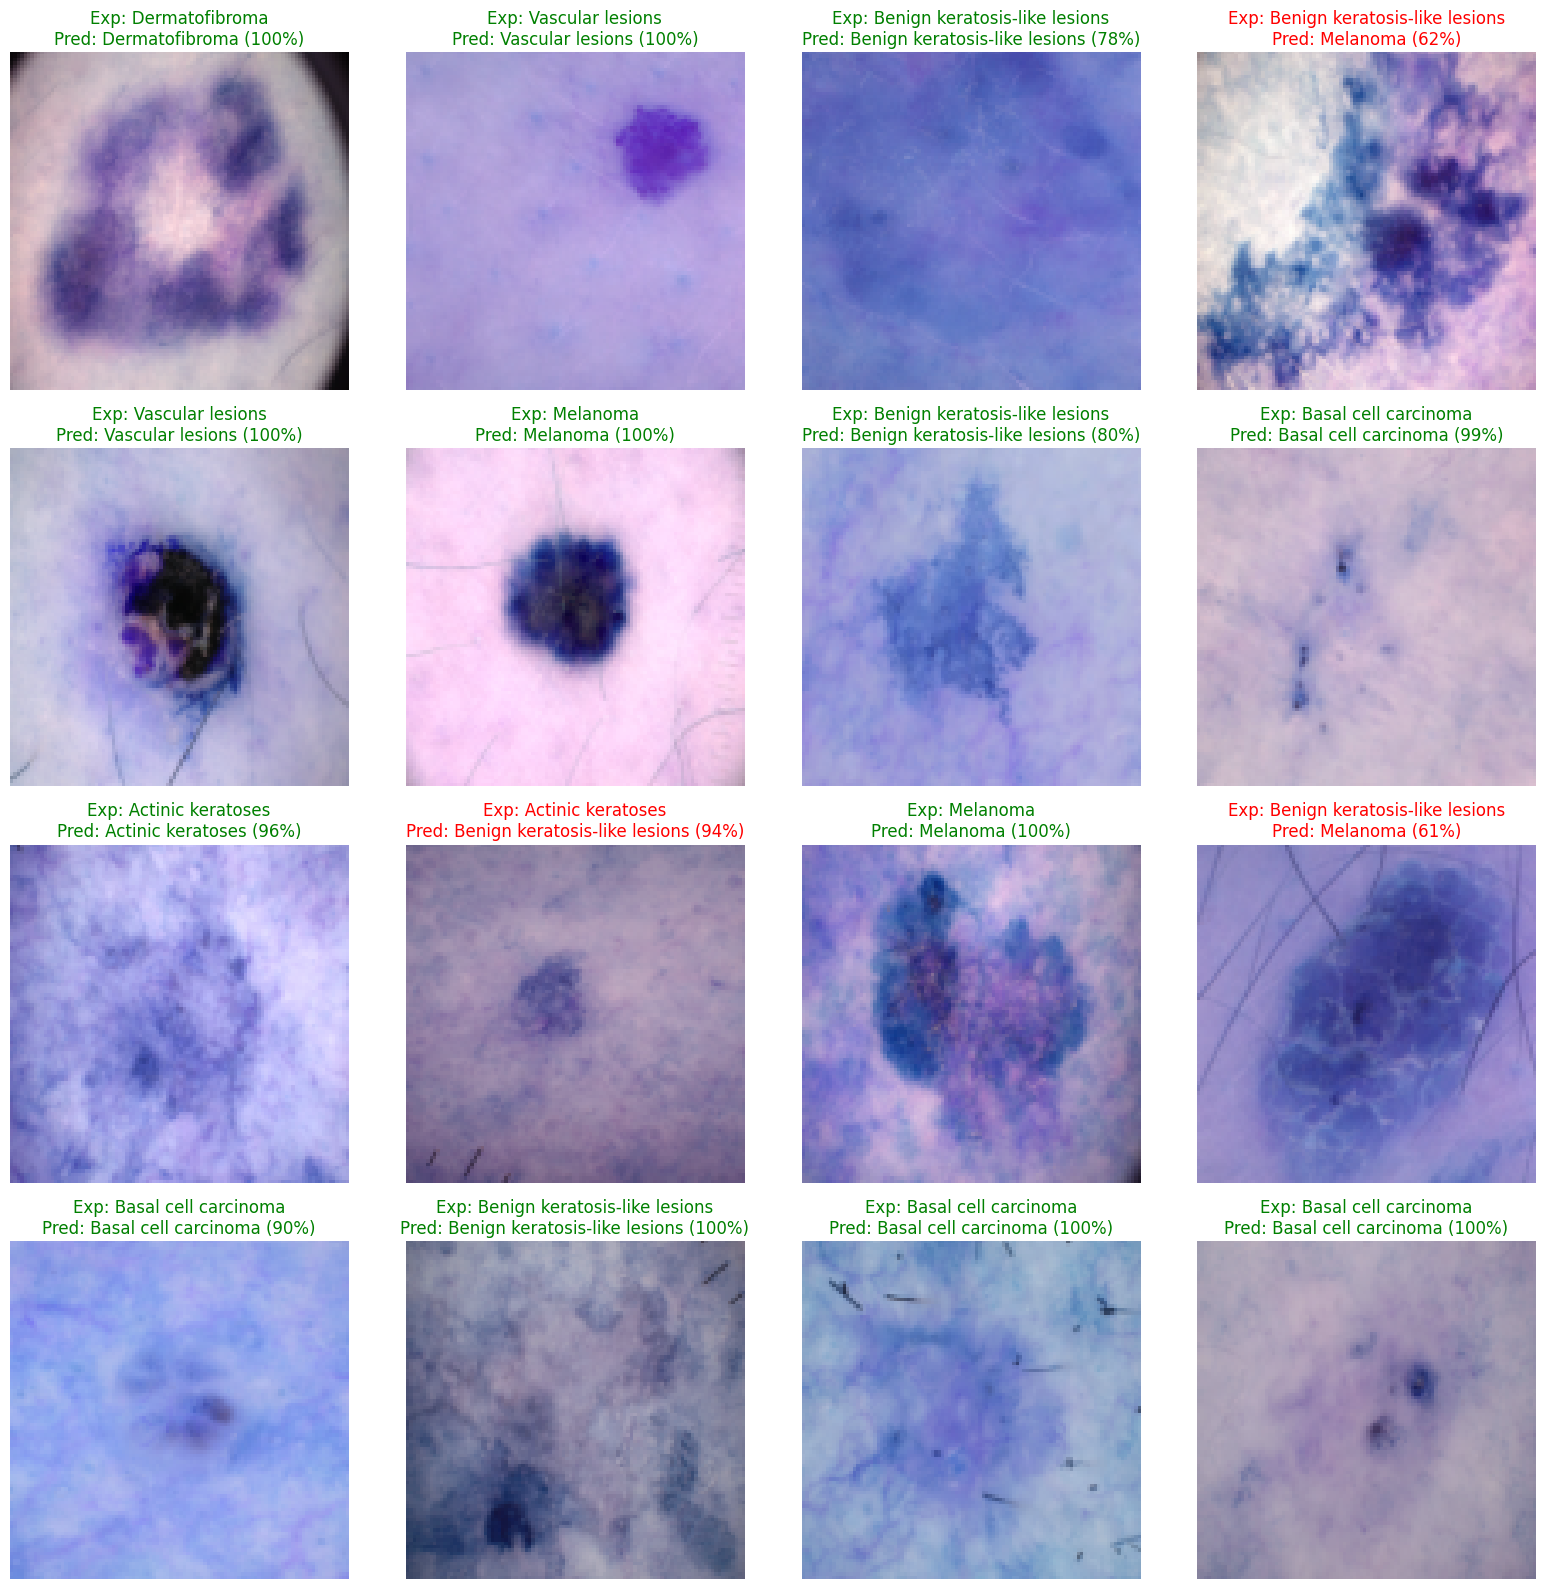

In [48]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    index = np.random.randint(0, len(X_test))  # Random samples
    plt.imshow(X_test[index,:,:,::-1])
    label_exp = lesion_names[y_test2[index]]
    label_pred = lesion_names[y_pred[index]]
    label_pred_prob = round(np.max(y_pred_prob[index]) * 100)
    color = 'green' if label_exp == label_pred else 'red'
    plt.title(f'Exp: {label_exp}\nPred: {label_pred} ({label_pred_prob}%)', color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()
